# Finger 2

## Enunciados

1) Encontrar los 5 anuncios cuya tasa de conversión (postulaciones al anuncio sobre visitas totales al anuncio) es la más alta.
  * **Nota:** Tener en cuenta que es posible que por ejemplo un anuncio con una visita y una postulación quede primero. Para evitar este inconveniente, tomar únicamente los avisos que poseen al menos un 25% de las visitas promedio que poseen los avisos. Por ejemplo, si el promedio de visitas de los avisos es 100, tomar solo los avisos que tengan al menos 25 visitas.
  * **Nota2:** Tener en cuenta también que los datos de vistas están incompletos. Solo podrá obtenerse la tasa de conversión para el período donde se tengan ambas informaciones (postulaciones y vistas).

2) Indicar la distribución de la edad de los postulantes

3) Realizar una visualización que nos permita analizar la evolución de cantidad de visitas por día y el nivel de estudio alcanzado por el postulante. El tipo de visualización será propuesto por el alumno.
  * **Nota:** Tener en cuenta que el nivel educativo del postulante dependerá de si el mismo fue completado, abandonado etc, por lo que para definir un nivel de estudio alcanzado hay que considerar tanto el nivel de estudios como el estado en el que se encuentra para el postulante: (Por ejemplo “Universitario En Curso” o “Universitario Abandonado” son casos válidos).


In [1]:
import findspark
findspark.init()
import pyspark
import os

# make sure pyspark tells workers to use python3 not 2 if both are installed
os.environ['PYSPARK_PYTHON'] = '/usr/bin/python3.6'

In [62]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import dates
from dateutil import parser
from datetime import date

In [3]:
sc = pyspark.SparkContext(appName="Finger2")

In [4]:
# Load CSVs.
postulantes_educacion = sc.textFile("file:///data/fiuba_1_postulantes_educacion.csv")
postulantes_genero_y_edad = sc.textFile("file:///data/fiuba_2_postulantes_genero_y_edad.csv")
visitas = sc.textFile("file:///data/fiuba_3_vistas.csv")
postulaciones = sc.textFile("file:///data/fiuba_4_postulaciones.csv")

In [5]:
# Split columns.
postulantes_educacion = postulantes_educacion.map(lambda x: x.split(','))
postulantes_genero_y_edad = postulantes_genero_y_edad.map(lambda x: x.split(','))
visitas = visitas.map(lambda x: x.split(','))
postulaciones = postulaciones.map(lambda x: x.split(','))

In [6]:
print(postulantes_educacion.count())
postulantes_educacion.take(5)

298232


[['idpostulante', 'nombre', 'estado'],
 ['NdJl', 'Posgrado', 'En Curso'],
 ['8BkL', 'Universitario', 'En Curso'],
 ['1d2B', 'Universitario', 'En Curso'],
 ['NPBx', 'Universitario', 'En Curso']]

In [7]:
print(postulantes_genero_y_edad.count())
postulantes_genero_y_edad.take(5)

200889


[['idpostulante', 'fechanacimiento', 'sexo'],
 ['NM5M', '1970-12-03', 'FEM'],
 ['5awk', '1962-12-04', 'FEM'],
 ['ZaO5', '1978-08-10', 'FEM'],
 ['NdJl', '1969-05-09', 'MASC']]

In [8]:
print(visitas.count())
visitas.top(5)

961898


[['idAviso', 'timestamp', 'idpostulante'],
 ['9240880', '2018-02-28T22:18:28.107-0500', '8MPVQeD'],
 ['5791240', '2018-02-25T09:53:33.747-0500', 'NzrEmqx'],
 ['3006520', '2018-02-27T18:26:44.163-0500', 'ZXQG65'],
 ['2613010', '2018-02-28T12:31:59.425-0500', '8MBzNE3']]

In [9]:
print(postulaciones.count())
postulaciones.take(5)

3401624


[['idaviso', 'idpostulante', 'fechapostulacion'],
 ['1112257047', 'NM5M', '2018-01-15 16:22:34'],
 ['1111920714', 'NM5M', '2018-02-06 09:04:50'],
 ['1112346945', 'NM5M', '2018-02-22 09:04:47'],
 ['1112345547', 'NM5M', '2018-02-22 09:04:59']]

In [10]:
# Remove headers.
postulantes_educacion = postulantes_educacion.filter(lambda x: not x[0].startswith('idpostulante'))
postulantes_genero_y_edad = postulantes_genero_y_edad.filter(lambda x: not x[0].startswith('idpostulante'))
visitas = visitas.filter(lambda x: not x[0].startswith('idAviso'))
postulaciones = postulaciones.filter(lambda x: not x[0].startswith('idaviso'))

## Ejercicio 1

**TODO:** utilizar unicamente los registros de los dias donde existen ambos datos, visitas y postulaciones. De otra forma tendremos muchas mas postulaciones que visitas, devolviendo resultados no esperados.

### Filtrar y graficar cantidad de visitas por aviso

Number of visitas: 961897
Number of avisos: 7458
Visitas mean: 129
Number of avisos filtered (visitas >= 25% of the visitas mean): 3888


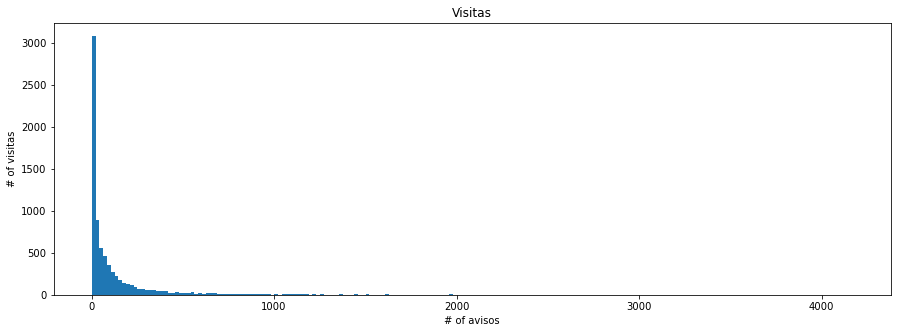

[('1112327963', 136),
 ('1112318643', 270),
 ('1112346704', 817),
 ('1112282610', 260),
 ('1112342544', 661)]

In [203]:
# ('1112327963', 136)
visitas_rdd_count = visitas.map(lambda x: (x[0], 1)).reduceByKey(lambda x, y: x + y)
# Returns number of visitas and number of unique avisos.
visitas_rdd_mean = visitas_rdd_count.map(lambda x: (x[1], 1)).reduce(lambda x, y: (x[0] + y[0], x[1] + y[1]))
visitas_mean = round(visitas_rdd_mean[0] / visitas_rdd_mean[1])

print("Number of visitas: %d" % visitas_rdd_mean[0])
print("Number of avisos: %d" % visitas_rdd_mean[1])
print("Visitas mean: %d" % visitas_mean)

# Filter by the 25% of the visitas mean.
visitas_rdd_filtered = visitas_rdd_count.filter(lambda x: x[1] >= visitas_mean / 4)
print("Number of avisos filtered (visitas >= 25%% of the visitas mean): %d" % visitas_rdd_filtered.count())

# Histogram.
plt.figure(figsize=(15, 5))
plt.hist(visitas_rdd_count.map(lambda x: x[1]).collect(), bins=200)
plt.title('Visitas')
plt.xlabel('# of avisos')
plt.ylabel('# of visitas')
plt.show()

visitas_rdd_filtered.take(5)

### Graficar cantidad de postulaciones por aviso

Number of postulaciones: 3401623
Number of avisos: 12692
Postulaciones mean: 268


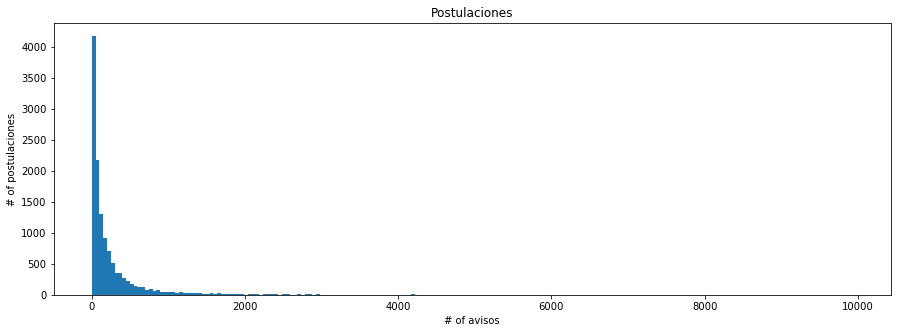

[('1112237522', 168),
 ('1112277633', 671),
 ('1112315393', 233),
 ('1112346738', 228),
 ('1112288401', 2058)]

In [204]:
# ('1112327963', 136)
postulaciones_rdd_count = postulaciones.map(lambda x: (x[0], 1)).reduceByKey(lambda x, y: x + y)
# Returns number of postulaciones and number of unique avisos.
postulaciones_rdd_mean = postulaciones_rdd_count.map(lambda x: (x[1], 1)).reduce(lambda x, y: (x[0] + y[0], x[1] + y[1]))
postulaciones_mean = round(postulaciones_rdd_mean[0] / postulaciones_rdd_mean[1])

print("Number of postulaciones: %d" % postulaciones_rdd_mean[0])
print("Number of avisos: %d" % postulaciones_rdd_mean[1])
print("Postulaciones mean: %d" % postulaciones_mean)

# Histogram.
plt.figure(figsize=(15, 5))
plt.hist(postulaciones_rdd_count.map(lambda x: x[1]).collect(), bins=200)
plt.title('Postulaciones')
plt.xlabel('# of avisos')
plt.ylabel('# of postulaciones')
plt.show()

postulaciones_rdd_count.take(5)

In [13]:
# Join both RDD, visitas and postulaciones
visitas_rdd_count_join = visitas_rdd_filtered.join(postulaciones_rdd_count)
visitas_rdd_count_join.take(5)

[('1112318643', (270, 683)),
 ('1112339122', (408, 2098)),
 ('1112357825', (643, 553)),
 ('1112288401', (60, 2058)),
 ('1112321767', (119, 424))]

### Avisos con mejor tasa de conversion

In [14]:
# Compute postulaciones / visitas, take the top 5
coversion_rate = visitas_rdd_count_join.map(lambda x: (x[0], x[1][1] / x[1][0])).sortBy(lambda x: x[1], ascending=False)
coversion_rate.take(5)

[('1111753681', 140.16666666666666),
 ('1112285953', 125.22222222222223),
 ('1112285529', 91.975),
 ('1112285124', 90.1951219512195),
 ('1112282268', 71.45238095238095)]

## Ejercicio 2

In [15]:
# Filter empty and wrong dates.
postulantes_genero_y_edad = postulantes_genero_y_edad.filter(lambda x: x[1].startswith('19') or x[1].startswith('20'))

In [16]:
# TODO: do not use parse library, try a faster method.
def calculate_age(x):
    born = parser.parse(x[1])
    today = date.today()
    age = today.year - born.year - ((today.month, today.day) < (born.month, born.day))
    return (age, 1)

In [17]:
# Get data summarized
hist = postulantes_genero_y_edad.map(calculate_age).reduceByKey(lambda x, y: x + y).collect()
hist[:10]

[(48, 1131),
 (42, 2394),
 (54, 590),
 (40, 3075),
 (44, 1718),
 (46, 1521),
 (52, 665),
 (50, 887),
 (30, 8377),
 (38, 3971)]

In [18]:
# Make a numpy array for easier manipulation
hist = np.array(hist)

### Graficar distribucion de edades

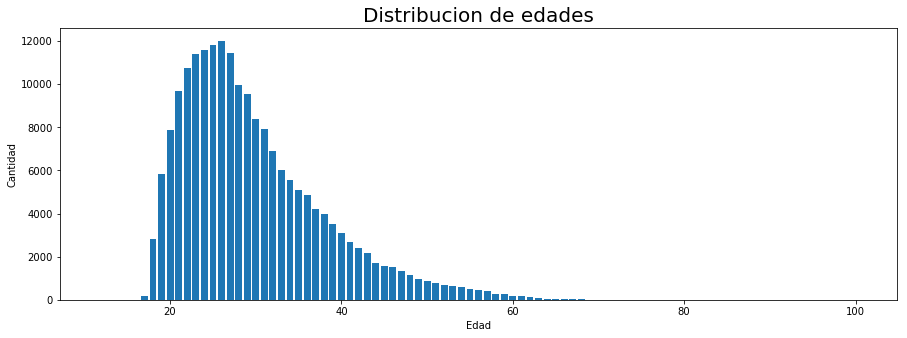

In [124]:
plt.figure(figsize=(15, 5))
plt.bar(hist[:, 0], hist[:, 1])
plt.title('Distribucion de edades', fontdict={'size':20})
plt.ylabel('Cantidad')
plt.xlabel('Edad')
plt.show()

## Ejercicio 3

In [118]:
print(postulantes_educacion.count())
postulantes_educacion.take(10)

298231


[['NdJl', 'Posgrado', 'En Curso'],
 ['8BkL', 'Universitario', 'En Curso'],
 ['1d2B', 'Universitario', 'En Curso'],
 ['NPBx', 'Universitario', 'En Curso'],
 ['NPBx', 'Master', 'En Curso'],
 ['Ym2X', 'Otro', 'En Curso'],
 ['ZKl5', 'Master', 'En Curso'],
 ['EDD99', 'Terciario/Técnico', 'En Curso'],
 ['Y043Z', 'Universitario', 'En Curso'],
 ['6M3jr', 'Universitario', 'En Curso']]

Cada visitante puede tener mas de un nivel de estudio, por lo tanto sus registros no son unicos. Para solucionarlo, nos quedamos con el nivel de estudio mas alto por cada visitante.

In [22]:
# Let's keep the higer education level per user.
def sort_education(x, y):
    max_ed = {
        'Doctorado': 1,
        'Master': 2,
        'Posgrado': 3,
        'Universitario': 4,
        'Terciario/Técnico': 5,
        'Secundario': 6,
        'Otro': 7
    }
    
    return x if max_ed[x.split(' ')[0]] < max_ed[y.split(' ')[0]] else y

In [23]:
postulantes_educacion_mayor = postulantes_educacion.map(lambda x: (x[0], x[1] + ' ' + x[2])).reduceByKey(lambda x, y: sort_education(x, y))
postulantes_educacion_mayor.take(10)

[('8BkL', 'Master Graduado'),
 ('EDD99', 'Universitario Graduado'),
 ('Y043Z', 'Universitario En Curso'),
 ('EpDDJ', 'Universitario En Curso'),
 ('YrkoJ', 'Master En Curso'),
 ('ZvqJ1', 'Universitario En Curso'),
 ('eZPbB', 'Posgrado Graduado'),
 ('aJ5N5', 'Posgrado Graduado'),
 ('Z48mz', 'Posgrado En Curso'),
 ('ex4j2', 'Universitario En Curso')]

Ahora tenemos aproximadamente 100 mil registros menos.

In [24]:
postulantes_educacion_mayor.count()

188752

### Graficar numero de postulaciones por nivel de estudios

In [207]:
palette = {
  'Doctorado Abandonado': '#990000',
  'Doctorado En Curso': '#FF3333',
  'Doctorado Graduado': '#FF9999',
  'Master Abandonado': '#999900',
  'Master En Curso': '#FFFF33',
  'Master Graduado': '#FFFF99',
  'Otro Abandonado': '#009900',
  'Otro En Curso': '#33FF33',
  'Otro Graduado': '#99FF99',
  'Posgrado Abandonado': '#009999',
  'Posgrado En Curso': '#33FFFF',
  'Posgrado Graduado': '#99FFFF',
  'Secundario Abandonado': '#000099',
  'Secundario En Curso': '#3333FF',
  'Secundario Graduado': '#9999FF',
  'Terciario/Técnico Abandonado': '#990099',
  'Terciario/Técnico En Curso': '#FF33FF',
  'Terciario/Técnico Graduado': '#FF99FF',
  'Universitario Abandonado': '#404040',
  'Universitario En Curso': '#A0A0A0',
  'Universitario Graduado': '#E0E0E0',
  'Sin dato': '#994C00',
}

In [208]:
nivel_educativo = postulantes_educacion.map(lambda x: (x[1] + ' ' + x[2], 1)).reduceByKey(lambda x, y: x + y).sortBy(lambda x: x[0])
nivel_educativo = np.array(nivel_educativo.collect())

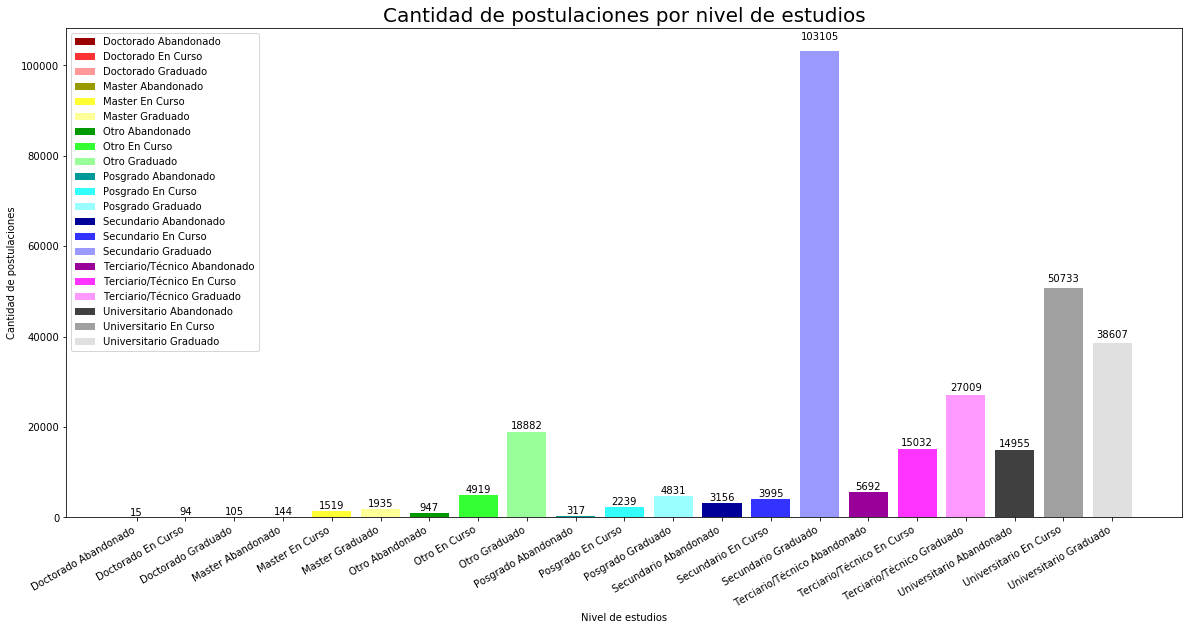

In [213]:
# See https://matplotlib.org/examples/api/barchart_demo.html

fig, ax = plt.subplots(figsize=(20,10))
fig.autofmt_xdate()

for key, item in enumerate(nivel_educativo):
    bar = ax.bar(key, int(item[1]), label=item[0], color=palette[item[0]])
    rect = bar[0]
    ax.text(rect.get_x() + rect.get_width() / 2, rect.get_height() * 1.02, item[1], ha='center', va='bottom')
    
ax.set_title('Cantidad de postulaciones por nivel de estudios', fontdict={'size':20})
ax.set_xticks(range(len(nivel_educativo)))
ax.set_xticklabels(nivel_educativo[:, 0])
ax.set_xlabel('Nivel de estudios')
ax.set_ylabel('Cantidad de postulaciones')
ax.legend()

plt.show()

### Graficar cantidad de postulaciones por nivel de estudios y fecha
**TODO:** separar en varios graficos para una mejor visualizacion

In [64]:
data = visitas.map(lambda x: (x[2], x[1][:10]))\
       .leftOuterJoin(postulantes_educacion_mayor)\
       .map(lambda x: ((x[1][0], ('Sin dato' if x[1][1] == None else x[1][1])), 1))\
       .reduceByKey(lambda x, y: x + y)\
       .groupBy(lambda x: x[0][1])\
       .map(lambda x: (x[0], [(y[0][0], y[1]) for y in x[1]]))\
       .collect()

In [110]:
data = sorted(data)
data[:4]

[('Doctorado Abandonado',
  [('2018-02-27', 7),
   ('2018-02-26', 36),
   ('2018-02-25', 4),
   ('2018-02-23', 2)]),
 ('Doctorado En Curso',
  [('2018-02-27', 57),
   ('2018-02-24', 13),
   ('2018-02-28', 148),
   ('2018-02-23', 23),
   ('2018-02-25', 26),
   ('2018-02-26', 112)]),
 ('Doctorado Graduado',
  [('2018-02-27', 122),
   ('2018-02-24', 20),
   ('2018-02-28', 173),
   ('2018-02-23', 13),
   ('2018-02-25', 59),
   ('2018-02-26', 182)]),
 ('Master Abandonado',
  [('2018-02-28', 178),
   ('2018-02-24', 40),
   ('2018-02-27', 188),
   ('2018-02-26', 225),
   ('2018-02-25', 76),
   ('2018-02-23', 14)])]

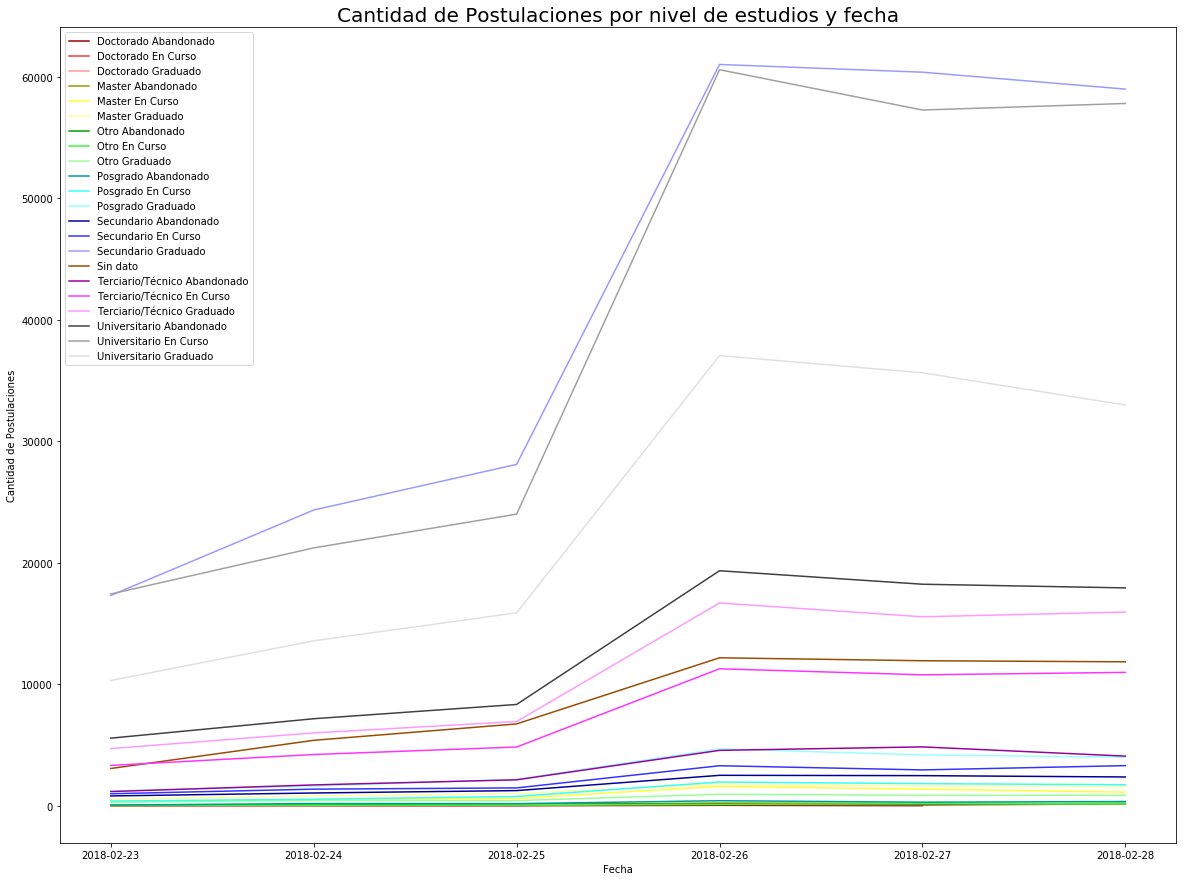

In [214]:
fig, ax = plt.subplots(figsize=(20,15))

ax.xaxis.set_major_formatter(dates.DateFormatter('%Y-%m-%d'))

for item in data:
    #print(np.array(item[1])[:, 0])
    items = np.array(sorted(item[1]))
    ax.plot(dates.datestr2num(items[:, 0]), items[:, 1], label=item[0], color=palette[item[0]])

ax.set_title('Cantidad de Postulaciones por nivel de estudios y fecha', fontdict={'size':20})
ax.set_xlabel('Fecha')
ax.set_ylabel('Cantidad de Postulaciones')
ax.legend()

plt.show()

In [28]:
sc.stop()